In [1]:
import numpy as np
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/calcofi/bottle.csv
/kaggle/input/calcofi/cast.csv


## Notes

**Regression Model Practice**

The following notebooks and links helped me understand linear regression and further develop my Machine Learning Skill-set.

- [Sudhir Kumar's Linear Regression Tutorial](https://www.kaggle.com/sudhirnl7/linear-regression-tutorial)
- [Fares Sayah's Linear Regression 📈 House 🏡 price 💵 prediction](https://www.kaggle.com/faressayah/linear-regression-house-price-prediction)
- [Ordinary Least Squares Explained Visually](https://setosa.io/ev/ordinary-least-squares-regression/)

This list is not exhaustive, and I used so many more resources than this to furhter understand OLS. If you have some links that you think I should add feel free to comment them below.

In [2]:
SEED = 123

### Data

I decided to use the CALCOFI Dataset which consists of over 60 years of oceanographic data samples. This dataset is nice and clean and great for practicing implementing regression models -> https://www.kaggle.com/mirichoi0218/insurance

I will be using only the water temperature and water salinity features in the dataset.

In [3]:
all_data = pd.read_csv('../input/calcofi/bottle.csv', usecols=["Salnty", "T_degC"])
print(all_data.shape)
all_data.head()

(864863, 2)


,T_degC,Salnty
0,10.50,33.440
1,10.46,33.440
2,10.46,33.437
3,10.45,33.420
4,10.45,33.421


## Linear Regression (Single Input/Single Output)

For this example I am using a single input variable and a single output variable in this linear regression model. Note that this dataset is extremely large, and I am only sampling a small number of rows. If we sampled all the rows it is more difficult to visualize the model.

Note: I dont know how representative of the real-world the dataset is, but it will be good enough for practice!

In [4]:
lr_data = all_data[:300].dropna(axis=0, how='any') #dropping rows with null values
lr_data = lr_data.sample(frac=1, random_state=SEED).reset_index(drop=True) #random shuffle of the data

#50-50 split
lr_train_data = lr_data[:int(len(lr_data)*0.5)]
lr_valid_data = lr_data[int(len(lr_data)*0.5):]

#checking we have no null vals
lr_train_data.isnull().sum()

T_degC    0
Salnty    0
dtype: int64

### Visualizing the Data

Seaborn Pairs Plot https://seaborn.pydata.org/generated/seaborn.pairplot.html
- A pairs plot allows us to see both distribution of single variables and relationships between two variables.
- This is a really helpful plot type that I should be using more.

In linear regression, the model is really sensitive to outliers so I may have to filter values that are in the extremes (depending on the sample).

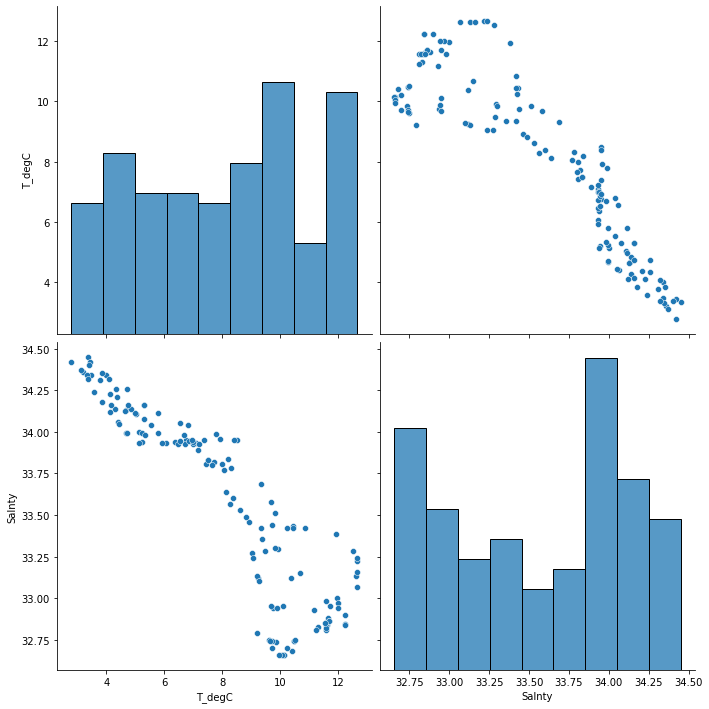

In [5]:
sns.pairplot(data=lr_train_data, height=5)

We can also use matplotlib for a more simple visualization.

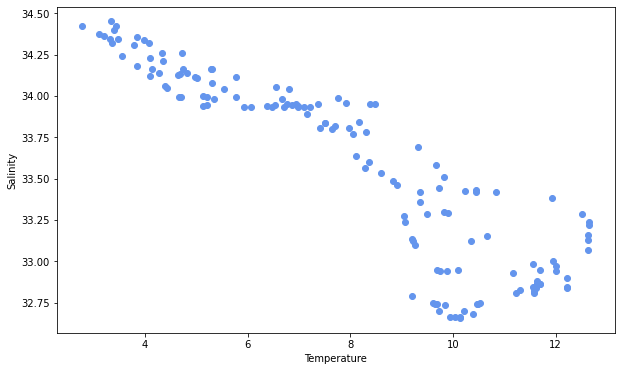

In [6]:
plt.figure(figsize=(10,6))
plt.scatter(lr_train_data["T_degC"], lr_train_data["Salnty"], color='cornflowerblue')
plt.xlabel("Temperature")
plt.ylabel("Salinity")
plt.show()

In [7]:
# converting from pandas dataframe - to numpy array
x_train = lr_train_data['Salnty'].values.reshape(-1, 1) #-1 = all
y_train = lr_train_data['T_degC'].values.reshape(-1, 1)
x_valid = lr_valid_data['Salnty'].values.reshape(-1, 1)
y_valid = lr_valid_data['T_degC'].values.reshape(-1, 1)
aug_x = np.hstack([x_train, np.ones_like(x_train)])

### OLS (Ordinary Least Squares)

Ordinary least squares is a method for getting the unknown parameters of a linear regression model. It chooses these parameters by minimizing the sum of the squares of the differences between the observed label and the predicted label.

The OLS formula is shown below and basically we are use this formula to find the Beta parameters which will minimize our loss.

![Ordinary Least Squares Formula](https://www.gstatic.com/education/formulas2/397133473/en/ordinary_least_squares.svg)

In [8]:
def ordinary_least_squares(x, y):
    xTx = x.T.dot(x)
    xTx_inv = np.linalg.inv(xTx)
    w = xTx_inv.dot(x.T.dot(y))
    return w

### MSE (Mean Squared Absolute Error)

For our loss function we will be using the MSE (Mean Squared Error). This is a measure that tells us how far/close the points are to the regression line. In other words, we are taking the square of the residuals.

We could simply take the absolute value of the residuals (distance from regression line) but then getting a close point even closer, or a far point a little but closer has the same value. If we take the squared sum of the residuals then we will have a better generalization for the whole of our data.

![Mean Square Error Formula](https://www.gstatic.com/education/formulas2/397133473/en/mean_squared_error.svg)

Note that a downside of MSE is that it is sensitive to outliers as they have a strong effect on the loss function and we can be mislead by this loss value.



In [9]:
def mean_squared_error(x, y, w):
    y_hat = x.dot(w)
    loss = np.mean((y - y_hat) ** 2)
    return loss

def avg_loss(x, y, w):
    y_hat = x.dot(w)
    loss = np.mean((y - y_hat) ** 2)
    return loss

### Linear Regression Model

To start we are defining two functions here. They are both use to plot a line to the polynomial function that we calculated to best fit our data.

See more about the specifics of Numpy here -> [Numpy Docs](https://numpy.org/doc/1.21/)

In [10]:
def polynomial(values, coeffs):
    assert len(values.shape) == 2
    # Coeffs are assumed to be in order 0, 1, ..., n-1
    expanded = np.hstack([coeffs[i] * (values ** i) for i in range(0, len(coeffs))])
    return np.sum(expanded, axis=-1)

def plot_polynomial(coeffs, x_range=[x_train.min(), x_train.max()], color='darkorange', label='polynomial', alpha=1.0):
    values = np.linspace(x_range[0], x_range[1], 1000).reshape([-1, 1])
    poly = polynomial(values, coeffs)
    plt.plot(values, poly, color=color, linewidth=2, label=label, alpha=alpha)

In the following cell we can see that we are able to use the two functions above and ordinary least squares to create a simple linear regression model that fits to our dataset.

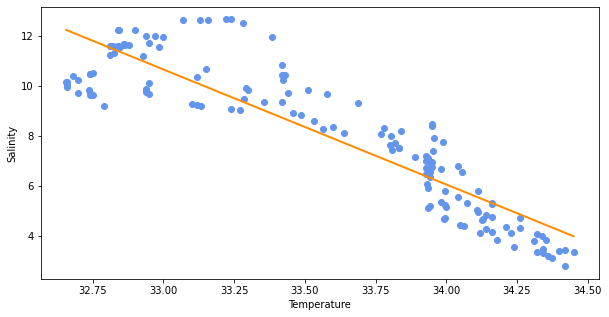

In [11]:
linear_coeff = ordinary_least_squares(aug_x, y_train)

plt.figure(figsize=(10, 5))
plt.scatter(x_train, y_train, color='cornflowerblue')
plt.xlabel("Temperature")
plt.ylabel("Salinity")
plot_polynomial([linear_coeff[1,0], linear_coeff[0,0]])

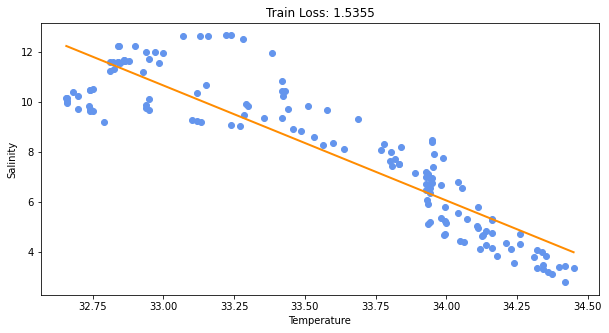

In [12]:
linear_coeff = ordinary_least_squares(aug_x, y_train)
loss = avg_loss(aug_x, y_train, linear_coeff)

plt.figure(figsize=(10, 5))
plt.scatter(x_train, y_train, color='cornflowerblue')
plt.xlabel("Temperature")
plt.ylabel("Salinity")
plt.title("Train Loss: {:.4f}".format(loss))
plot_polynomial([linear_coeff[1,0], linear_coeff[0,0]])

### Linear Regression that is non-linear?

This really confused me when I first heard it, but once it makes sense it is very simple.

The co-efficients that are the parameters in our model are linear in nature, and when multiply these by their respective degree's of x, we can map a non-linear model to these linear inputs.

![Linear Coefficients Pic](https://s0.wp.com/latex.php?latex=Y+%3D%5Cbeta+_%7B0%7D+%2B+%5Cbeta+_%7B1%7DX_%7B1%7D+%2B+%5Cbeta+_%7B2%7DX_%7B2%7D+%2B+%5Ccdots+%2B+%5Cbeta+_%7Bk%7DX_%7Bk%7D&bg=ffffff&fg=000&s=0&c=20201002&is-pending-load=1)

For more info on Linear Regression, check out this article here -> [Linear vs Non-Linear Regression](https://statisticsbyjim.com/regression/difference-between-linear-nonlinear-regression-models/)

In [13]:
def polynomial_features(x, order):
    features = np.hstack([x**i for i in range(0, order+1)])
    return features

def plot_regression(x, y, degree):
    features = polynomial_features(x, degree)
    w = ordinary_least_squares(features, y)
    loss = mean_squared_error(features, y, w)
    
    plt.figure(figsize=(10, 5))
    plt.scatter(x_train, y_train, color='cornflowerblue')
    plot_polynomial(w)
    plt.title("Polynomial degree: {}, Train MSE: {:.4f}".format(degree,loss))

So, by increasing the degree of the polynomial above 1, we can fit to "non-linear" data.

In the following cell we are plotting a degree 2 polynomial. We can see that as we increase the degree of the polynomial, we are able to better fit our model to the training data. On every degree increase the loss will decrease!

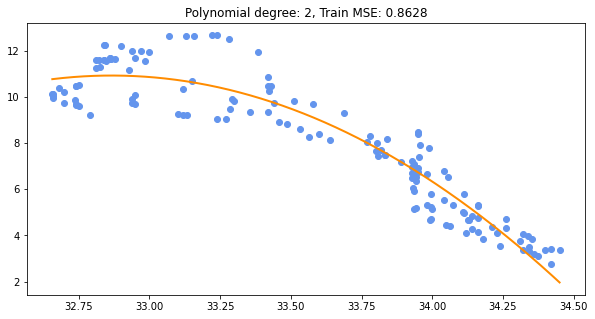

In [14]:
plot_regression(x_train, y_train, 2)

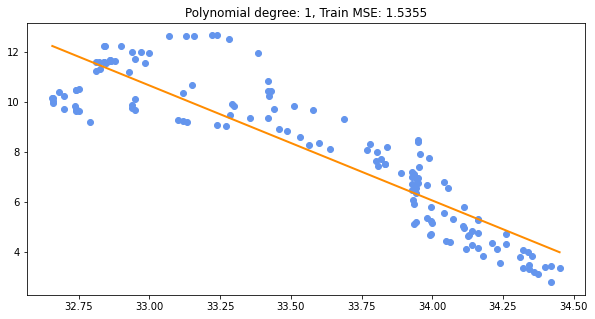

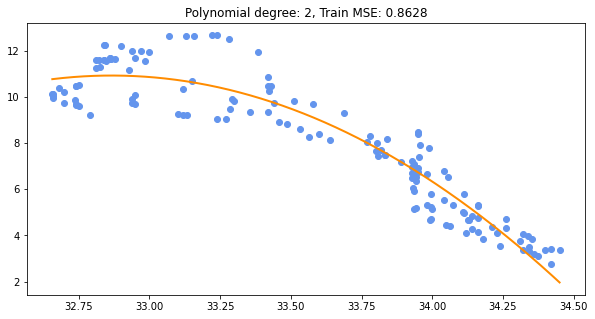

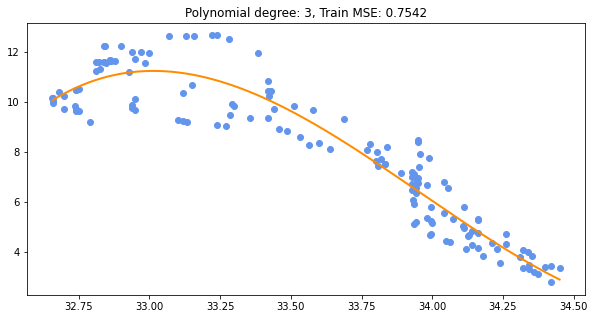

In [15]:
for i in range(1,4):
    plot_regression(x_train, y_train, i)

Although we may be fitting well to the training data, in practice we should be evaluating the model on a seperate dataset to get an unbiased estimate of model performance.

This can be done in two ways.
- Using a Training, Validation and Test set.
- Using Cross-Validation.

In the following cell I am implementing a function that increases the model complexity until a threshold is not met. Then, I am plotting the function against a validation set.

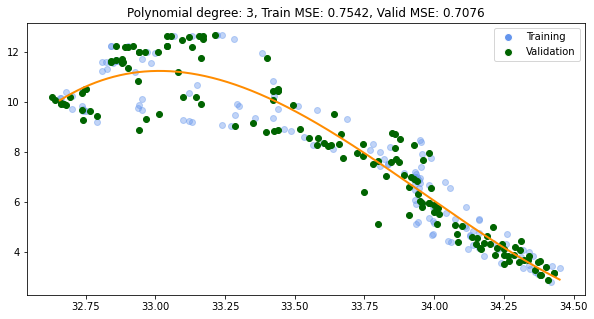

In [16]:
def find_best_model_degree(x_train, y_train, x_valid, y_valid, threshold=0.2):
    last_loss = None
    for degree in range(1, 100):
        # fitting model
        features = polynomial_features(x_train, degree)
        w = ordinary_least_squares(features, y_train)

        # evaluating model on validation set
        features_new = polynomial_features(x_valid, degree)
        loss = avg_loss(features_new, y_valid, w)
        
        if last_loss == None or (loss < last_loss - threshold):
            last_loss = loss
        else:
            break
    return degree

def plot_regression_with_validation(x_train, y_train, x_valid, y_valid, degree):
    # getting polynomial coefficients
    features = polynomial_features(x_train, degree)
    w = ordinary_least_squares(features, y_train)
    train_loss = mean_squared_error(features, y_train, w)
    
    # validation loss
    features_new = polynomial_features(x_valid, degree)
    valid_loss = avg_loss(features_new, y_valid, w)
    
    # plotting results
    plt.figure(figsize=(10, 5))
    plt.scatter(x_train, y_train, color='cornflowerblue', alpha=0.4)
    plt.scatter(x_valid, y_valid, color='darkgreen')
    plot_polynomial(w)
    legend_elements = [
                        Line2D([0], [0], marker='o', color='w', label='Training',
                          markerfacecolor='cornflowerblue', markersize=8),
                        Line2D([0], [0], marker='o', color='w', label='Validation',
                          markerfacecolor='darkgreen', markersize=8)
                      ]
    plt.legend(handles=legend_elements, loc='upper right')
    plt.title("Polynomial degree: {}, Train MSE: {:.4f}, Valid MSE: {:.4f}".format(degree, train_loss, valid_loss))
        
degree = find_best_model_degree(x_train, y_train, x_valid, y_valid, 0.2)
plot_regression_with_validation(x_train, y_train, x_valid, y_valid, degree)